# Bayesian variable selection

The data for the variable selection in major depressive disorder was obtained from the Nathan Kline Institute - Rockland Sample. As we cannot share these data here, we use instead a simulated example.

In [1]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [0]


In [20]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  

import jax.random as jrnd
import jax.numpy as jnp
import blackjax
import pandas as pd
import jax.scipy.special as jsp

import numpyro as npr
import numpyro.distributions as dist
import numpyro.distributions.transforms as nprb

import sys
from blackjax import normal_random_walk

import bamojax
from bamojax.base import Node, Model
from bamojax.samplers import gibbs_sampler, mcmc_sampler
from bamojax.inference import SMCInference, MCMCInference

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Numpyro version:      ', npr.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

Python version:        3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Jax version:           0.7.2
BlackJax version:      1.2.5
Numpyro version:       0.19.0
BaMoJax version:       0.2.0+49.gcbc3356.dirty
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


In [3]:
DATA_DIR = '/home/maxhin/Documents/Code/SMC tutorial/BLR/data/Request all'
RESULTS_DIR = '/home/maxhin/Documents/Code/SMC tutorial/BLR'
FIGURES_DIR = 'figures'


def read_data(key, N=100, add_intercept=False):   
    key, key_X, key_y = jrnd.split(key, 3)
    beta_true = jnp.array([1.0, 0.0, 0.0, 4.3, -2.8])
    p = len(beta_true)    
    X = jrnd.normal(key_X, shape=(N, p))
    sigma_true = 0.7
    y = jnp.dot(X, beta_true) + sigma_true*jrnd.normal(key_y, shape=(N, ))
    labels = None
    if add_intercept:
        X = jnp.column_stack((jnp.ones((X.shape[0], )), X))  # add intercept! -> note that it doesn't do anything...
        if labels != None:
            labels.insert(0, 'Intercept')
    return X, y, labels

#

In [4]:
def boxplot_coefficients(ax, samples, ylabel, labels=None, sortbysize=True):
    
    mean = jnp.mean(samples, axis=0)
    p = len(mean)
    if sortbysize:
        ix = jnp.argsort(jnp.abs(mean))[::-1]
    else:
        ix = jnp.arange(p)
    samples = samples[:, ix]

    if labels == None:
        labels = p*['']
    elif labels == 'infer':
        labels = [r'$x_{{{:d}}}$'.format(i) for i in jnp.arange(p)[ix]]
    else:
        labels = [labels[i] for i in ix]

    ax.axhline(y=0.0, lw=0.5, color='k', ls='--')
    bp = ax.boxplot(samples,
                    patch_artist=True, 
                    tick_labels=labels,
                    boxprops=dict(facecolor='#FDB97D',
                                  linewidth=0.5),
                    showcaps=False,
                    medianprops=dict(color='k',
                                     linestyle='-',
                                     linewidth=0.5),
                    whiskerprops=dict(solid_capstyle='butt',
                                      linewidth=0.5),
                    showfliers=False)

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel('Predictors')
    ax.set_ylabel(ylabel)
    return bp

#

Regular linear regression with Gaussian priors (ridge regression):

In [5]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

print('Loading data')
X, y, labels = read_data(subkey, N=100, add_intercept=True)
p = X.shape[1]

def lin_reg_link_fn(beta, sigma, x):
    mu = jnp.dot(x, beta)
    return dict(loc=mu, scale=sigma)

#

LinearRegression = Model('BLR')
sigma = LinearRegression.add_node('sigma', distribution=dist.TransformedDistribution(dist.Normal(loc=0., scale=1.), nprb.ExpTransform()))
beta = LinearRegression.add_node('beta', distribution=dist.Normal(loc=0., scale=1.), shape=(p, ))
x_node = LinearRegression.add_node('x', observations=X)
y_node = LinearRegression.add_node('y', observations=y, distribution=dist.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

print('Gibbs conditionals: ')
LinearRegression.print_gibbs()

Loading data
Gibbs conditionals: 
Gibbs structure:
beta                : p(y | sigma, x, beta) p(beta)
sigma               : p(y | sigma, x, beta) p(sigma)


In [7]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(beta=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05*jnp.eye(p)), sigma=dict(sigma=0.3))

gibbs = gibbs_sampler(LinearRegression, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
engine = SMCInference(model=LinearRegression, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps)

result = engine.run(subkey)
final_state = result['final_state']
lml = result['lml']
n_iter = result['n_iter']
final_info = result['final_info']

for theta in ['beta', 'sigma']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for beta: 0.481
Acceptance rate for sigma: 0.229
CPU times: user 17.5 s, sys: 791 ms, total: 18.3 s
Wall time: 12.9 s


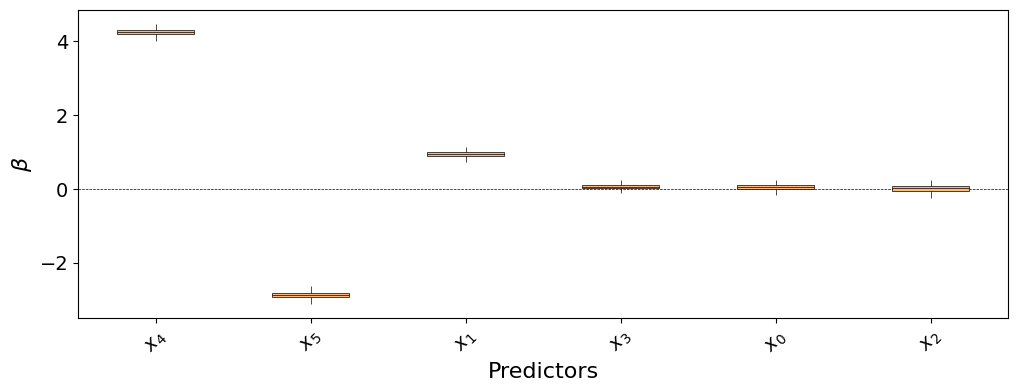

In [8]:
plt.figure(figsize=(12, 4))
_ = boxplot_coefficients(plt.gca(), final_state.particles['beta'], r'$\beta$', sortbysize=True, labels='infer')

Variable selection with the LN-CASS prior (regularizing coefficients towards zero; see Thomson et al., 2019):

In [10]:
mu_v = jsp.logit(0.2)
sigma_v = 1.0 

def lin_reg_link_fn(beta, sigma, x):
    mu = jnp.dot(x, beta)
    return dict(loc=mu, scale=sigma)

#

LNCASS = Model('SBLR')
sigma = LNCASS.add_node('sigma', distribution=dist.TransformedDistribution(dist.Normal(loc=0., scale=1.), nprb.ExpTransform()))
tau = LNCASS.add_node('tau', distribution=dist.TransformedDistribution(dist.Normal(loc=0., scale=1.), nprb.ExpTransform()))
lam = LNCASS.add_node('lam', dist.TransformedDistribution(dist.Normal(loc=mu_v*jnp.ones((p, )), scale=sigma_v*jnp.ones((p, ))), nprb.SigmoidTransform()))
beta = LNCASS.add_node('beta', distribution=dist.Normal, parents=dict(tau=tau, lam=lam), link_fn=lambda tau, lam: dict(loc=0.0, scale=(tau*lam)**2))
x_node = LNCASS.add_node('x', observations=X)
y_node = LNCASS.add_node('y', observations=y, distribution=dist.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

LNCASS.print_gibbs()

Gibbs structure:
tau                 : p(beta | lam, tau) p(tau)
lam                 : p(beta | lam, tau) p(lam)
beta                : p(y | sigma, x, beta) p(beta | lam, tau)
sigma               : p(y | sigma, x, beta) p(sigma)


In [11]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(beta=normal_random_walk, 
                sigma=normal_random_walk, 
                lam=normal_random_walk, 
                tau=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05*jnp.eye(p)), 
                      lam=dict(sigma=0.01*jnp.eye(p)), 
                      sigma=dict(sigma=0.5), 
                      tau=dict(sigma=0.5))

gibbs = gibbs_sampler(LNCASS, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
engine = SMCInference(model=LNCASS, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps)

result = engine.run(subkey)
final_state = result['final_state']
lml = result['lml']
n_iter = result['n_iter']
final_info = result['final_info']

for theta in ['beta', 'sigma', 'lam', 'tau']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for beta: 0.373
Acceptance rate for sigma: 0.138
Acceptance rate for lam: 0.801
Acceptance rate for tau: 0.760
CPU times: user 14.6 s, sys: 554 ms, total: 15.2 s
Wall time: 11.4 s


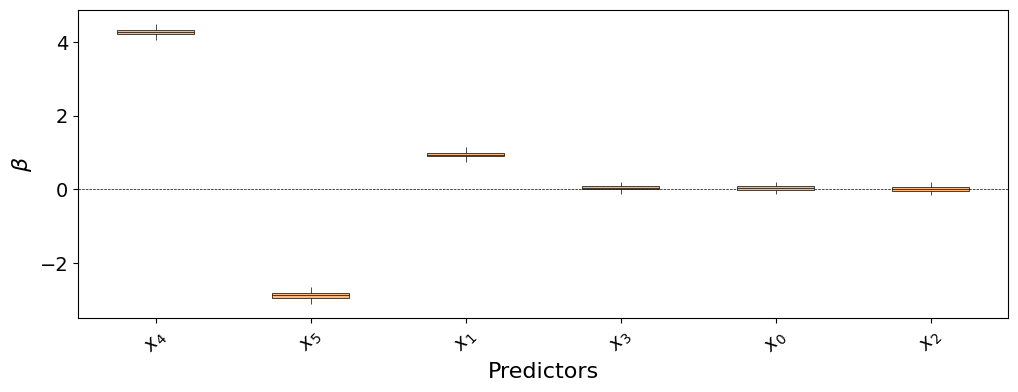

In [12]:
plt.figure(figsize=(12, 4))
_ = boxplot_coefficients(plt.gca(), final_state.particles['beta'], r'$\beta$', sortbysize=True, labels='infer')

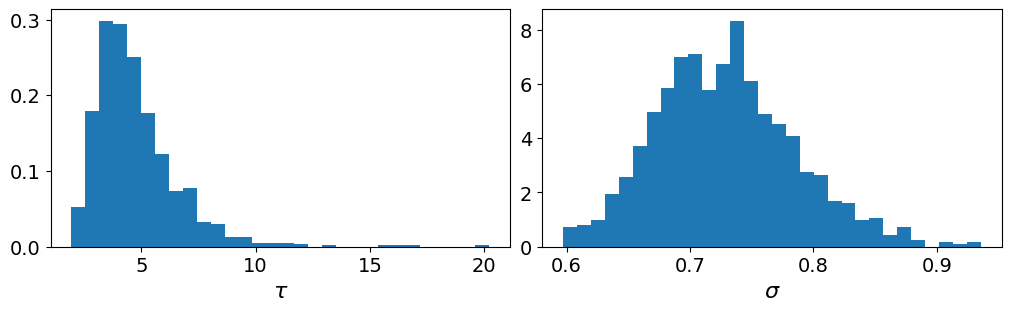

In [13]:
_, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 3))
for ax, theta in zip(axes, ['tau', 'sigma']):
    ax.hist(final_state.particles[theta], density=True, bins=30)
    ax.set_xlabel(fr'$\{theta}$')

Recall that true $\sigma=0.7$.

# Latent binary variables

See Schäfer & Chopin.

In [14]:
import jax.flatten_util
from blackjax.types import Array, ArrayLikeTree, ArrayTree, PRNGKey
from blackjax.base import SamplingAlgorithm
from typing import Callable


def generate_bernoulli_noise(rng_key: PRNGKey, position, theta):
    p, unravel_fn = jax.flatten_util.ravel_pytree(position)
    sample = jrnd.bernoulli(rng_key, shape=p.shape, p=theta)
    return unravel_fn(sample)

#
def bernoulli(theta: Array) -> Callable:
    def propose(rng_key: PRNGKey, position) -> ArrayTree:
        return generate_bernoulli_noise(rng_key, position, theta=theta)
    
    #
    return propose

#
def build_xor_step():
    def kernel(
        rng_key: PRNGKey, state, logdensity_fn: Callable, random_step: Callable
    ):
        def proposal_generator(key_proposal, position):
            move_proposal = jax.tree_util.tree_map(lambda x: x.astype(int), random_step(key_proposal, position)) 
            new_position = jax.tree_util.tree_map(jnp.bitwise_xor, position, move_proposal)
            return new_position

        inner_kernel = blackjax.mcmc.random_walk.build_rmh()
        return inner_kernel(rng_key, state, logdensity_fn, proposal_generator)

    return kernel

#  
def xor_step_random_walk(logdensity_fn: Callable, random_step: Callable) -> SamplingAlgorithm:

    kernel = build_xor_step()
    def init_fn(position: ArrayLikeTree, rng_key=None):
        del rng_key
        return blackjax.mcmc.random_walk.init(position, logdensity_fn)

    def step_fn(rng_key: PRNGKey, state):
        return kernel(rng_key, state, logdensity_fn, random_step)

    return SamplingAlgorithm(init_fn, step_fn)

#
def bernoulli_random_walk(logdensity_fn: Callable, theta):
    return xor_step_random_walk(logdensity_fn, bernoulli(theta))

#

Simulate data and determine MLE.

In [15]:
def least_squares(X, y):
    N, p = X.shape
    beta_mle = jnp.linalg.lstsq(X, y, rcond=None)[0]
    residuals = y - X @ beta_mle
    sigma2_mle = jnp.sum(residuals**2) / (N - p)
    return beta_mle, sigma2_mle

#

key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)
X, y, labels = read_data(subkey, N=100, add_intercept=True)
N, p = X.shape
print('X.shape:', X.shape)

beta_mle, sigma2_mle = least_squares(X, y)

print(beta_mle)
print(jnp.sqrt(sigma2_mle))

X.shape: (100, 6)
[ 0.04782598  0.95581145  0.01697426  0.06581821  4.28277871 -2.89183515]
0.7249426226088519


In [18]:
def lin_reg_link_fn(beta, gamma, sigma2, x):
    mu = jnp.dot(x, gamma*beta)
    return dict(loc=mu, scale=jnp.sqrt(sigma2))

#
def beta_gaussian_link_fn(loc, sigma2, v2, gamma, epsilon=1e-8):
    return dict(loc=loc, scale=sigma2 * v2 * gamma + epsilon)

#
w = 4.0
sigma2_hat = sigma2_mle
lmbda = sigma2_hat
v2 =10.0 / lmbda

LBV = Model('LBV')
sigma2 = LBV.add_node('sigma2', distribution=dist.InverseGamma(concentration=w/2, rate=lmbda*w/2))
theta = LBV.add_node('theta', distribution=dist.Beta(concentration1=1.0, concentration0=1.0), shape=(p, ))
gamma = LBV.add_node('gamma', distribution=dist.Bernoulli, parents=dict(probs=theta))
beta = LBV.add_node('beta', distribution=dist.Normal, parents=dict(loc=0.0, sigma2=sigma2, v2=v2, gamma=gamma), link_fn=beta_gaussian_link_fn)
x_node = LBV.add_node('x', observations=X)
y_node = LBV.add_node('y', observations=y, distribution=dist.Normal, parents=dict(beta=beta, gamma=gamma, sigma2=sigma2, x=x_node), link_fn=lin_reg_link_fn)

LBV.print_gibbs()

Gibbs structure:
sigma2              : p(y | gamma, x, sigma2, beta) p(beta | gamma, v2_beta, sigma2, loc_beta) p(sigma2)
theta               : p(gamma | theta) p(theta)
gamma               : p(y | gamma, x, sigma2, beta) p(beta | gamma, v2_beta, sigma2, loc_beta) p(gamma | theta)
beta                : p(y | gamma, x, sigma2, beta) p(beta | gamma, v2_beta, sigma2, loc_beta)


### Gibbs

In [19]:
step_fns = dict(beta=normal_random_walk, 
                sigma2=normal_random_walk, 
                gamma=bernoulli_random_walk,
                theta=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.01*jnp.eye(p)),
                      sigma2=dict(sigma=0.1), 
                      gamma=dict(theta=0.2),
                      theta=dict(sigma=0.1))

gibbs = gibbs_sampler(LBV, step_fns=step_fns, step_fn_params=step_fn_params)

In [24]:
%%time

key = jrnd.PRNGKey(1234)
key, subkey = jrnd.split(key)

engine = MCMCInference(model=LBV, mcmc_kernel=gibbs, num_burn=100_000, num_chains=4, num_samples=100_000, num_thin=100, return_diagnostics=True)

result = engine.run(subkey)
gibbs_states = result['states']
gibbs_info = result['info']

print('Inclusion probability:', jnp.mean(gibbs_states['gamma'], axis=jnp.array([1])))
print('beta:', jnp.mean(gibbs_states['beta'], axis=jnp.array([1])))

for var in gibbs_info.keys():
    print(f'{var}: {jnp.mean(gibbs_info[var].is_accepted):0.2f}')

Inclusion probability: [[1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1.]]
beta: [[ 4.43346117e-02  9.53525793e-01  1.74994926e-02  6.73692640e-02
   4.27995174e+00 -2.89241827e+00]
 [ 1.21455905e+01 -7.37356489e-09  3.40996700e-01 -7.11124595e+00
   2.09939191e+01 -1.13610581e-08]
 [ 2.85634439e+01  1.03552148e-08  4.47118282e+01  6.74099301e-09
   1.26472566e-08 -3.97834772e+01]
 [ 5.38076428e-09 -4.14589827e-09  1.01986291e+01 -6.16717630e-09
  -2.54694281e-08  1.73999764e+00]]
beta: 0.19
gamma: 0.26
sigma2: 0.72
theta: 0.49
CPU times: user 19.9 s, sys: 8.41 s, total: 28.3 s
Wall time: 26.8 s


### Gibbs-in-SMC

In [26]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

num_mcmc_steps = 300
num_particles = 1_000
num_chains = 4

engine = SMCInference(model=LBV, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, num_chains=num_chains)

result = engine.run(subkey)
final_state = result['final_state']
lml = result['lml']
n_iter = result['n_iter']
final_info = result['final_info']

print('Acceptance rates')
for var in final_state.particles:
    ar = jnp.mean(final_info.update_info[var].is_accepted)
    print(f'{var}: {ar:0.3f}')

Acceptance rates
beta: 0.768
gamma: 0.262
sigma2: 0.376
theta: 0.479


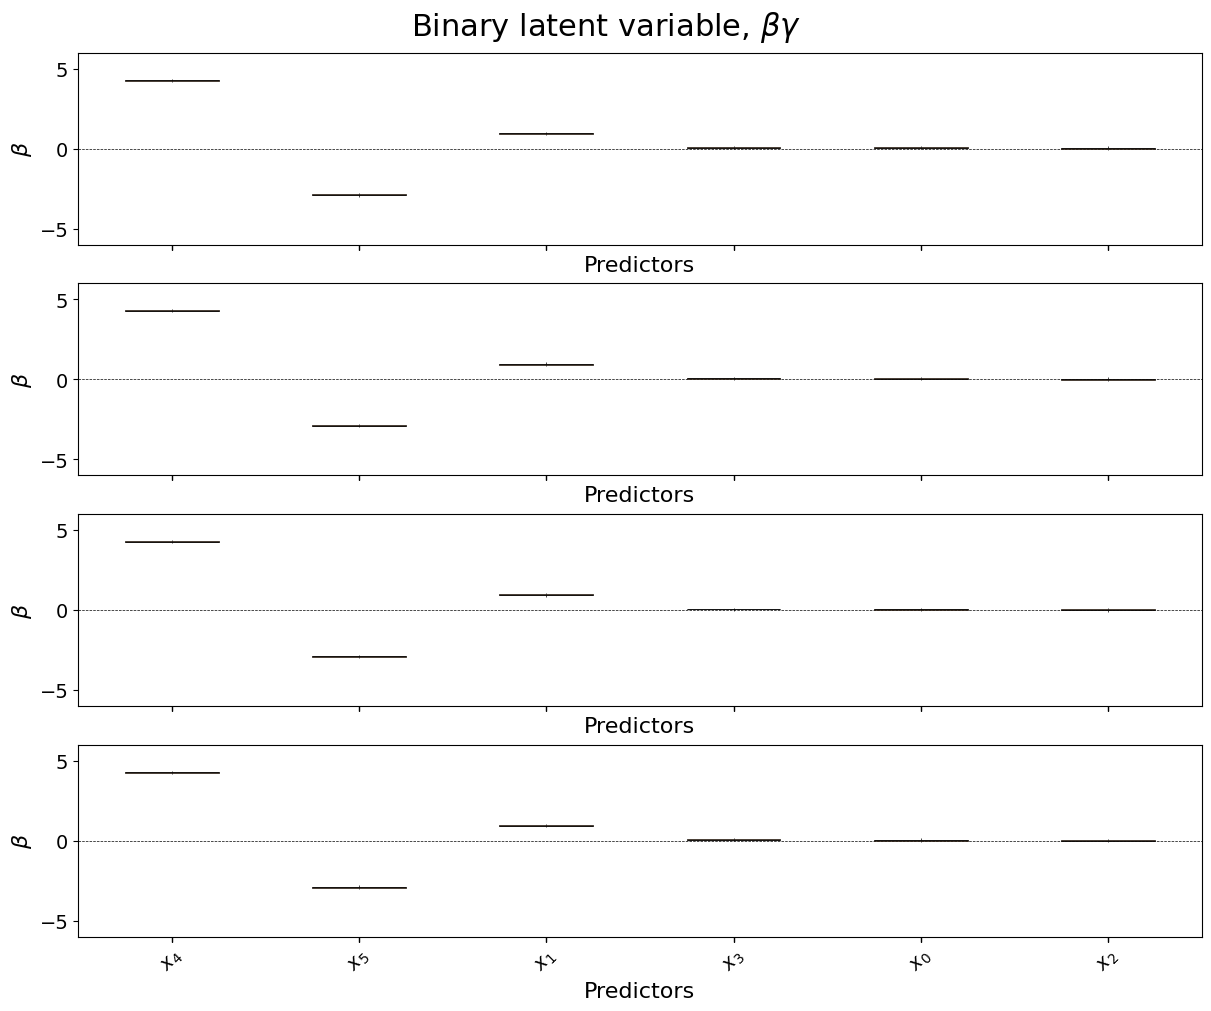

In [27]:
_, axes = plt.subplots(nrows=num_chains, ncols=1, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 10))

for c, ax in enumerate(axes):
    if c == num_chains - 1:
        _ = boxplot_coefficients(ax, final_state.particles['beta'][c, ...], r'$\beta$', sortbysize=True, labels='infer')
    else:
        _ = boxplot_coefficients(ax, final_state.particles['beta'][c, ...], r'$\beta$', sortbysize=True)

for ax in axes:
    ax.set_ylim([-6, 6])

plt.suptitle(r'Binary latent variable, $\beta\gamma$');

In [28]:
print('Inclusion probability:', jnp.mean(final_state.particles['gamma'], axis=jnp.array([0, 1])))
print('beta:', jnp.mean(final_state.particles['beta'], axis=jnp.array([0, 1])))
print('Sigma2:', jnp.mean(final_state.particles['sigma2'], axis=jnp.array([0, 1])))

Inclusion probability: [1.      1.      0.99775 0.99875 1.      1.     ]
beta: [ 0.04790203  0.95510561  0.01663356  0.06520401  4.28250955 -2.89124949]
Sigma2: 0.1607484924840793


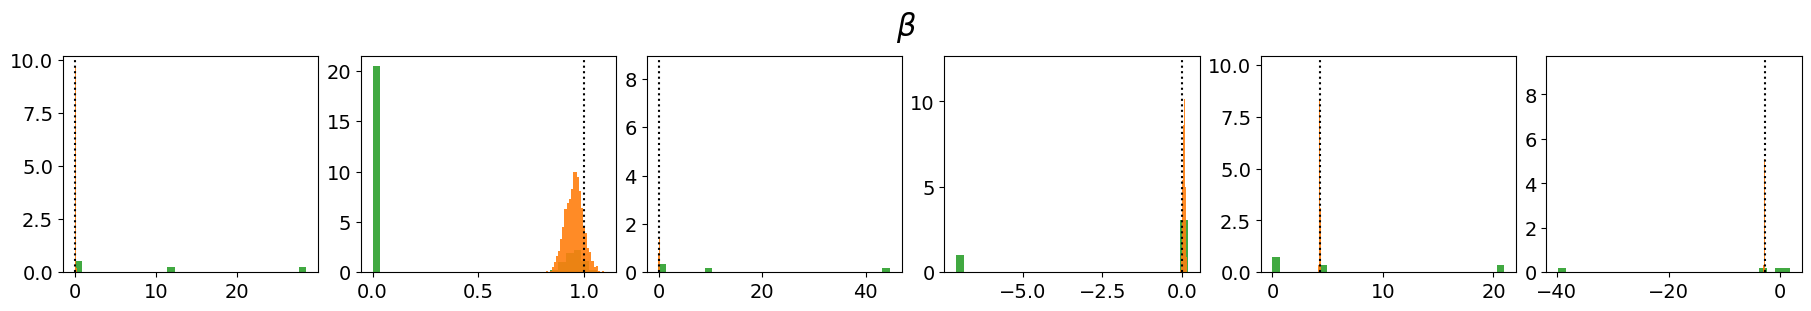

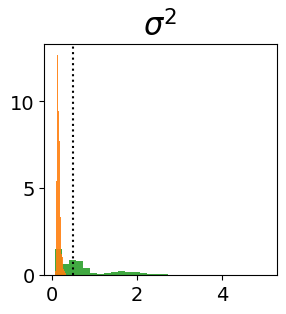

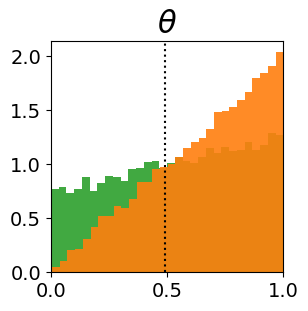

In [30]:
sigma_true = 0.7
beta_true = jnp.array([0.0, 1.0, 0.0, 0.0, 4.3, -2.8])

num_bins = 30

_, axes = plt.subplots(nrows=1, ncols=p, constrained_layout=True, figsize=(18, 3))
for j in range(p):
    axes[j].hist(gibbs_states['beta'][..., j].flatten(), density=True, bins=num_bins, color='tab:green', alpha=0.9)
    axes[j].hist(final_state.particles['beta'][..., j].flatten(), density=True, bins=num_bins, color='tab:orange', alpha=0.9)
    axes[j].axvline(x=beta_true[j], color='k', ls=':')
plt.suptitle(r'$\beta$')    

plt.figure(figsize=(3,3))
ax = plt.gca()
ax.hist(gibbs_states['sigma2'].flatten(), density=True, bins=num_bins, color='tab:green', alpha=0.9)
ax.hist(final_state.particles['sigma2'].flatten(), density=True, bins=num_bins, color='tab:orange', alpha=0.9)
ax.axvline(x=sigma_true**2, color='k', ls=':')
ax.set_title(r'$\sigma^2$');

plt.figure(figsize=(3,3))
ax = plt.gca()
ax.hist(gibbs_states['theta'].flatten(), density=True, bins=num_bins, color='tab:green', alpha=0.9)
ax.hist(final_state.particles['theta'].flatten(), density=True, bins=num_bins, color='tab:orange', alpha=0.9)
ax.axvline(x=sigma_true**2, color='k', ls=':')
ax.set_xlim([0.0, 1.0])
ax.set_title(r'$\theta$');

In [31]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

samples = [gibbs_states, final_state.particles]
names = ['Gibbs', 'Gibbs-in-SMC']

for s, name in zip(samples, names):
    print(f'Inference: {name}')
    for key in s.keys():
        ESS = effective_sample_size(s[key], chain_axis=0, sample_axis=1)
        print(f'({name}) {key} ESS: ')
        print(ESS)
        R = potential_scale_reduction(s[key], chain_axis=0, sample_axis=1)
        print(f'({name}) {key} PSRF: ')
        print(R)

Inference: Gibbs
(Gibbs) beta ESS: 
[2.00200665 2.00615468 2.00200443 2.00205223 2.00201133 2.00200461]
(Gibbs) beta PSRF: 
[674.54561144  22.65224202 943.84032602 204.79070798 476.08488768
 907.24043151]
(Gibbs) gamma ESS: 
[2.002002e+00 2.002002e+00 1.440824e+04 2.002002e+00 2.002002e+00
 2.002002e+00]
(Gibbs) gamma PSRF: 
[inf inf nan inf inf inf]
(Gibbs) sigma2 ESS: 
2.3728423231423132
(Gibbs) sigma2 PSRF: 
2.608161412767207
(Gibbs) theta ESS: 
[   6.27715405    6.23748566 3630.01809955    4.88052585    5.30054389
    5.95683957]
(Gibbs) theta PSRF: 
[1.22685563 1.22979081 1.00033663 1.31733534 1.28231253 1.24301438]
Inference: Gibbs-in-SMC
(Gibbs-in-SMC) beta ESS: 
[3698.55452007 4076.06647475 4036.86213862 3481.65386965 3777.95213292
 3431.69103252]
(Gibbs-in-SMC) beta PSRF: 
[0.99997262 0.99964202 0.99971483 1.00061202 0.99951227 0.99959065]
(Gibbs-in-SMC) gamma ESS: 
[14408.23996531 14408.23996531   555.30222203   801.62087098
 14408.23996531 14408.23996531]
(Gibbs-in-SMC) gamm

## todo

- Schäfer & Chopin's model definition
- Run on Bainter dataset; record PSRF and ESS
- Compare Gibbs vs SMC (see S&C for metrics?)